In [1]:
import numpy as np 
import pandas as pd
import sklearn 
import tensorflow as tf 
import nltk
import gensim 
import json
import re
import string
import contractions

### Load Data

In [2]:
# Read dataset.json as a dictionary object 
with open('dataset.json', 'r') as file:
    json_str = file.read()
    json_dic = json.loads(json_str)


In [3]:
# Convert dictionary object to pandas dataframe 
df = pd.DataFrame.from_dict(json_dic).T
df['post_tokens_string'] = df['post_tokens'].apply(lambda x: ' '.join(x))
df.head()

,post_id,annotators,rationales,post_tokens,post_tokens_string
1179055004553900032_twitter,1179055004553900032_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...",[],"[i, dont, think, im, getting, my, baby, them, ...",i dont think im getting my baby them white 9 h...
1179063826874032128_twitter,1179063826874032128_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...",[],"[we, cannot, continue, calling, ourselves, fem...",we cannot continue calling ourselves feminists...
1178793830532956161_twitter,1178793830532956161_twitter,"[{'label': 'normal', 'annotator_id': 4, 'targe...",[],"[nawt, yall, niggers, ignoring, me]",nawt yall niggers ignoring me
1179088797964763136_twitter,1179088797964763136_twitter,"[{'label': 'hatespeech', 'annotator_id': 1, 't...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<user>, i, am, bit, confused, coz, chinese, p...",<user> i am bit confused coz chinese ppl can n...
1179085312976445440_twitter,1179085312976445440_twitter,"[{'label': 'hatespeech', 'annotator_id': 4, 't...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[this, bitch, in, whataburger, eating, a, burg...",this bitch in whataburger eating a burger with...


### Pre-Process Data

In [4]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import ssl

# try:
#     _create_unverified_https_context = ssl._create_unverified_context
# except AttributeError:
#     pass
# else:
#     ssl._create_default_https_context = _create_unverified_https_context

# nltk.download()

# download a create set of stopwords
nltk.download('stopwords')
stopwords = set(stopwords.words("english"))

# exclude set contains punctuation
exclude = set(string.punctuation)

# create lemmatizer
lemmatizer = WordNetLemmatizer()

#     # Paramaters: text_features: text (tweet) data in our dataframe.
#     # When determining how to return the processed data, consider the format your data needs to be in for train_test_split and model training
 
def clean_text(text_features):
    # tokenize and lower case
    tokens = word_tokenize(text_features.lower())

    # remove stopwords
    tokens = [x for x in tokens if x not in stopwords]

    # remove punctuation 
    tokens = [token for token in tokens if token not in exclude]

    # remove non alphabetical characters
    tokens = [x for x in tokens if any(char.isalpha() for char in x)]

    # undo contractions
    tokens = [contractions.fix(token) for token in tokens]

    # lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens 

[nltk_data] Error loading stopwords: <urlopen error [SSL:
[nltk_data]     CERTIFICATE_VERIFY_FAILED] certificate verify failed:
[nltk_data]     unable to get local issuer certificate (_ssl.c:1002)>


In [5]:
# Labels text based on majority of annotators

from collections import Counter

df['post_tokens_cleaned'] = df['post_tokens_string'].apply(clean_text)

def majority_label(annotations):
    labels = [annotation['label'] for annotation in annotations]
    counter = Counter(labels)
    majority_label = counter.most_common(1)[0][0]
    return 0 if majority_label == 'normal' else 1

df['label'] = df['annotators'].apply(majority_label)

df.head()

,post_id,annotators,rationales,post_tokens,post_tokens_string,post_tokens_cleaned,label
1179055004553900032_twitter,1179055004553900032_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...",[],"[i, dont, think, im, getting, my, baby, them, ...",i dont think im getting my baby them white 9 h...,"[do not, think, i am, getting, baby, white, tw...",0
1179063826874032128_twitter,1179063826874032128_twitter,"[{'label': 'normal', 'annotator_id': 1, 'targe...",[],"[we, cannot, continue, calling, ourselves, fem...",we cannot continue calling ourselves feminists...,"[continue, calling, feminist, right, womxn, ar...",0
1178793830532956161_twitter,1178793830532956161_twitter,"[{'label': 'normal', 'annotator_id': 4, 'targe...",[],"[nawt, yall, niggers, ignoring, me]",nawt yall niggers ignoring me,"[nawt, you all, nigger, ignoring]",0
1179088797964763136_twitter,1179088797964763136_twitter,"[{'label': 'hatespeech', 'annotator_id': 1, 't...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[<user>, i, am, bit, confused, coz, chinese, p...",<user> i am bit confused coz chinese ppl can n...,"[user, bit, confused, coz, chinese, people, ac...",1
1179085312976445440_twitter,1179085312976445440_twitter,"[{'label': 'hatespeech', 'annotator_id': 4, 't...","[[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[this, bitch, in, whataburger, eating, a, burg...",this bitch in whataburger eating a burger with...,"[bitch, whataburger, eating, burger, top, bun,...",1


In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec

    # Later: Sentence2Vec or Doc2Vec

def flatten(l):
        return [item for sublist in l for item in sublist]

def vectorize_text(cleaned_text, use_word2vec=True):
    model = Word2Vec(cleaned_text, min_count=1)
    
    feature_matrix = []

    for sentence in cleaned_text:

        vectors = []
        word_count = len(sentence)

        for word in sentence:
             vectors.append(model.wv[word].tolist())

        averaged_vector = []

        # Calculate average vector for each word in sentence
        for i in range(0, len(vectors[0])):
            count = 0
            
            for v in vectors:
                count += v[i]
                
            avg = count/word_count
            
            averaged_vector.append(avg)
            
        feature_matrix.append(averaged_vector)

    return feature_matrix

In [7]:
feature_matrix = vectorize_text(df['post_tokens_cleaned'])

print(len(feature_matrix), len(feature_matrix[0]))

20148 100


### Model Training: KNN/Random Forest/RNNs

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(feature_matrix, df["label"].values)

##### Using KNN
###### Refer to this resource: https://scikit-learn.org/stable/modules/neighbors.html#nearest-neighbors-classification

In [9]:
# Determine initial value of parameters (K, distance computation metric)
k = 15

candidate_metrics = ['euclidean','cosine','manhattan']
best_metric = 'cosine'

In [10]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=k, metric=best_metric)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

In [11]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6587254318046456


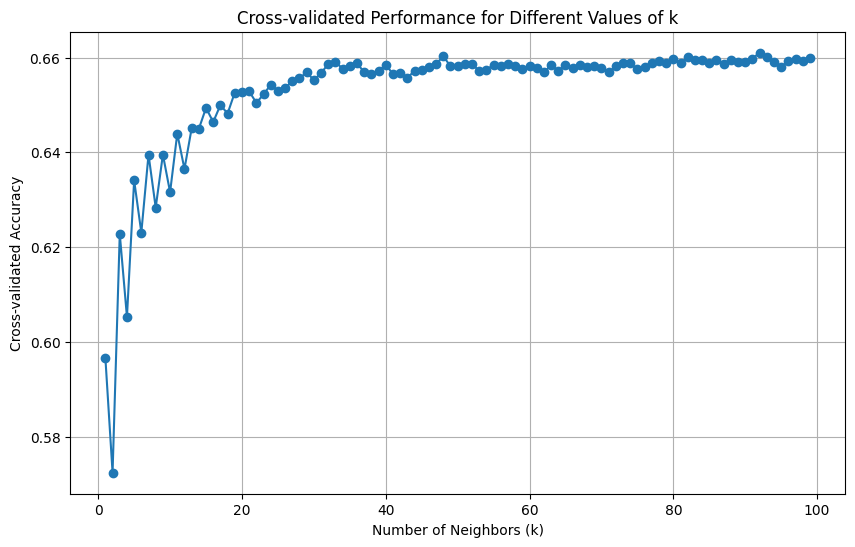

Best k: 92


In [12]:
# Optimize K with hyperparameter tuning
# Visualize results to determine best K

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score

k_values = np.arange(1, 100)

cv_scores = []

for k in k_values:
    knn_classifier = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn_classifier, X_train, y_train, cv=5, scoring='accuracy')
    cv_scores.append(np.mean(scores))

plt.figure(figsize=(10, 6))
plt.plot(k_values, cv_scores, marker='o')
plt.title('Cross-validated Performance for Different Values of k')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Cross-validated Accuracy')
plt.grid(True)
plt.show()

best_k = k_values[np.argmax(cv_scores)]
print(f"Best k: {best_k}")


In [13]:
# Repeat with optimized K
knn = KNeighborsClassifier(n_neighbors=best_k, metric='cosine')
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(accuracy)

0.6676593210244193


##### Using XGBoost/Random Forest
###### Refer to this resource: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

In [14]:
# Train model naively, with default parameters
from sklearn.ensemble import RandomForestClassifier

rf_classifier = RandomForestClassifier()

rf_classifier.fit(X_train, y_train)

y_pred_rf = rf_classifier.predict(X_test)

In [15]:
# Evaluate base model
from sklearn.metrics import accuracy_score

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f"Random Forest Classifier Accuracy: {accuracy_rf}")


Random Forest Classifier Accuracy: 0.6730196545562835


In [16]:
# Hyperparameter Tuning via RandomizedSearch & GridSearch 

# get current parameters and their values 
from pprint import pprint
from scipy.stats import randint

print(rf_classifier.get_params())

# Randomized Search 
from sklearn.model_selection import RandomizedSearchCV
random_grid = {
    'n_estimators': randint(10, 20),
    'max_features': ['sqrt', 'log2'],
    'max_depth': randint(1, 4),
    'min_samples_split': randint(2, 4),
    'min_samples_leaf': randint(1, 4),
    'bootstrap': [True]
}
rf_random = RandomizedSearchCV(rf_classifier, param_distributions=random_grid, n_iter=100, cv=5, scoring='accuracy', random_state=42)

rf_random.fit(X_train, y_train)

y_pred_rf_random = rf_classifier.predict(X_test)

accuracy_rf_random = accuracy_score(y_test, y_pred_rf_random)
print(f"Random Forest Classifier Accuracy (RandomizedSearchCV): {accuracy_rf_random}")

# Grid Search
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10, 15, 20],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [1, 2, 3],
    'min_samples_split': [2, 3],
    'min_samples_leaf': [1, 2, 3],
    'bootstrap': [True]
}

grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

y_pred_rf_grid = grid_search.predict(X_test)

accuracy_rf_grid = accuracy_score(y_test, y_pred_rf_grid)
print(f"Random Forest Classifier Accuracy (Grid Search): {accuracy_rf_grid}")


{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
Random Forest Classifier Accuracy (RandomizedSearchCV): 0.6730196545562835
Best Hyperparameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 15}
Random Forest Classifier Accuracy (Grid Search): 0.6543577526305341


##### Using LSTMs
###### Refer to this resource: https://www.youtube.com/watch?v=8HyCNIVRbSU&ab_channel=TheA.I.Hacker-MichaelPhi

In [19]:
from tensorflow.python.keras.layers import LSTM, Activation, Dropout, Dense, Embedding
from tensorflow.python.keras.models import Sequential
from keras_preprocessing.sequence import pad_sequences


In [20]:
# veryyyyyy basic architecture. TO-DO: complete and expand

model = Sequential()
model.add(Embedding())
model.add(LSTM())
model.add(Dense(2, activation='softmax'))

model.compile(loss='',optimizer='', metrics=['accuracy'])

TypeError: Embedding.__init__() missing 2 required positional arguments: 'input_dim' and 'output_dim'

In [ ]:
epochs = 0
batch_size = 0

## TO-DO: determine training parameters and complete call
model.fit()

In [ ]:
## TO-DO: evaluate function 
model.evaluate()

### Using BERT
###### Refer to: http://jalammar.github.io/illustrated-bert/ 
###### Refer to: https://medium.com/@parthdholakiya180/twitter-hate-detection-using-bert-e7682b2d0a0c 

In [ ]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer